# First part is the full code. The discussion is attached after the full code.

# YOLO-v1

# Download and unzip data

In [ ]:
!gdown 1PyCuPC1ajLTwBD7Avpqt6CkkvOEv-6Aj -O dataset.zip

In [ ]:
!gdown 1qBpfM1xcWl8Gb5osVKyp3YuVAF5zXxBN -O dataset2.zip

In [ ]:
!unzip dataset.zip

In [ ]:
!unzip dataset2.zip

Move cut file to current training folder

In [ ]:
import shutil
import os

# Define source folder and destination location
#source_folder = '/content/2024-datalab-cup2-object-detection'
source_folder = '/home/jieshiang/Desktop/Deep-Learning-Lab/Comp2/data_cutout'
destination_folder = '/home/jieshiang/Desktop/Deep-Learning-Lab/Comp2'

# Iterate over the first level of files and folders in the source folder
for item in os.listdir(source_folder):
    source_path = os.path.join(source_folder, item)
    destination_path = os.path.join(destination_folder, item)

    # Move files or folders to the destination folder
    shutil.move(source_path, destination_path)

print("Successfully moved the first-level contents of the folder to the current folder!")

In [ ]:
import os
import shutil

# Define source and destination folders
source_folder = './cut_out_train_data'
destination_folder = './VOCdevkit_train/VOC2007/JPEGImages/'

# Move image files
for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)

        # Move the file
    shutil.move(source_file, destination_file)
    print(f'Moved: {filename}')

print("All images have been moved.")

In [ ]:
# Define the paths to the two text files
file1_path = './cut_out_train_data.txt'
file2_path = './pascal_voc_training_data.txt'
output_file_path = './pascal_voc_training_data2.txt'

# Open the output file in write mode
with open(output_file_path, 'w') as output_file:
    # Read and write contents of the first file
    with open(file1_path, 'r') as file1:
        output_file.write(file1.read())

    # Read and write contents of the second file
    with open(file2_path, 'r') as file2:
        output_file.write(file2.read())

print("Files have been concatenated successfully.")

Visualize function

# Dataset Loader / Predefined

In [ ]:
import tensorflow as tf
import numpy as np
import sys
import os

from datetime import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 32
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 42

# dataset params
DATA_PATH = './pascal_voc_training_data2.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 50

In [ ]:
import tensorflow as tf
import numpy as np

import albumentations as A
import cv2
import random

import matplotlib.pyplot as plt

class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []

        max_objects = 0

        print("Starting to load dataset...")
        input_file = open(DATA_PATH, 'r')

        max_record_length = 0
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            records = [float(num) for num in ss[1:]]
            max_record_length = max(max_record_length, len(records))

        input_file.seek(0)

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')

            self.image_names.append(ss[0])

            records = [float(num) for num in ss[1:]]
            num_objects = len(records) // 5

            max_objects = max(max_objects, num_objects)

            if len(records) < max_record_length:
                padding = [0.0] * (max_record_length - len(records))
                records.extend(padding)

            self.record_list.append(records)
            self.object_num_list.append(num_objects)

        input_file.close()

        print(f"Dataset loaded:")
        print(f"- Total images: {len(self.image_names)}")
        print(f"- Maximum objects in a single image: {max_objects}")
        print(f"- Record length after padding: {max_record_length}")

    def aug_fn(self, image, bbox):
        # Convert the TensorFlow tensor to a NumPy array
        image = image.numpy()
        bbox = bbox.numpy()

        # Ensure the original bbox is not empty
        if len(bbox) == 0:
            return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(bbox, dtype=tf.float32)

        transform = A.Compose([
            A.VerticalFlip(p=0.5),  # Randomly flip the image vertically
            A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=0.5),  # Adjust hue, saturation, and value
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
            A.GaussianBlur(blur_limit=7, p=0.3),  # Apply random Gaussian blur
            A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, p=0.5), # Randomly obscured portions of the image
        ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.0))

        data = {"image": image, "bboxes": bbox}
        aug_data = transform(**data)
        aug_image = aug_data["image"]
        aug_bboxes = aug_data['bboxes']

        # Convert the NumPy array back to a TensorFlow tensor
        aug_image = tf.convert_to_tensor(aug_image, dtype=tf.float32)
        aug_bboxes = tf.convert_to_tensor(aug_bboxes, dtype=tf.float32)

        return aug_image, aug_bboxes

    def aug_data(self, image, bbox):
        aug_image, aug_bboxes = tf.py_function(func=self.aug_fn, inp=[image, bbox], Tout=[tf.float32, tf.float32])

        aug_image.set_shape([None, None, 3])
        aug_bboxes.set_shape([None, 5])

        return aug_image, aug_bboxes


    def _data_preprocess(self, image_name, raw_labels, object_num):
        """
        Preprocess a single data sample
        Args:
        image_name: image file name
        raw_labels: label data
        object_num: number of objects
        """
        image_file = tf.io.read_file(IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        #get only rows < object_num
        raw_labels_real = raw_labels[:object_num]
        #set padding aside, later for reconcacenate
        raw_labels_pad = raw_labels[object_num:]

        image, raw_labels_real = self.aug_data(image, raw_labels_real)

        raw_labels = tf.concat([raw_labels_real, raw_labels_pad], axis=0)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1



        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio
        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)


    def generate(self):
        """
        生成dataset
        Returns:
            tf.data.Dataset: 處理好的data
        """
        dataset = tf.data.Dataset.from_tensor_slices((
            self.image_names,
            np.array(self.record_list),
            np.array(self.object_num_list)
        ))

        for names, records, nums in dataset.take(1):
            print("\nFirst sample shapes:")
            print(f"- Records shape: {tf.shape(records)}")
            print(f"- Object num: {nums}")

        dataset = dataset.shuffle(100000)
        dataset = dataset.repeat(8)#repeat dataset for augmentation
        dataset = dataset.map(
            self._data_preprocess,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        for images, labels, nums in dataset.take(1):
            print("\nFirst batch shapes after processing:")
            print(f"- Images shape: {tf.shape(images)}")
            print(f"- Labels shape: {tf.shape(labels)}")
            print(f"- Object nums shape: {tf.shape(nums)}")

        return dataset

# Object Detection Model (YOLO)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG19, Xception, NASNetLarge
from tensorflow.keras.applications.inception_v3 import InceptionV3

backbone = Xception(include_top=False,
                       weights='imagenet',
                       input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze 4/5 of the layers
freeze_until = int(len(backbone.layers) * 0.7)  # Calculate 4/5 of the layers

for layer in backbone.layers[:freeze_until]:
    layer.trainable = False

img_inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = backbone(img_inputs)

x = layers.Flatten()(x)

x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)

outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = tf.keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 xception (Functional)       (None, 14, 14, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 4096)              1644171264
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1470)              6022590   
                                                                 
Total params: 1671055334 (6.23 GB)
Trainable params: 166074818

# Define loss

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initialize each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

def yolo_loss(predicts, labels, objects_num):
    """
    Calculate loss for YOLO training
    Args:
        predicts: shape [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        labels: shape [batch_size, max_objects, 5]
        objects_num: shape [batch_size]
    """
    #tf.print("\nActual shapes in loss calculation:")
    #tf.print("- predicts:", tf.shape(predicts))
    #tf.print("- labels:", tf.shape(labels))
    #tf.print("- objects_num:", tf.shape(objects_num))

    loss = 0.0
    batch_size = tf.shape(predicts)[0]

    for i in tf.range(batch_size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        object_num = tf.minimum(object_num, tf.shape(label)[0])

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss / tf.cast(batch_size, tf.float32)

def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate object mask tensor [CELL_SIZE, CELL_SIZE]
    min_x = tf.floor((label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE))
    max_x = tf.minimum(tf.math.ceil((label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)), CELL_SIZE)

    min_y = tf.floor((label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE))
    max_y = tf.minimum(tf.math.ceil((label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)), CELL_SIZE)

    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate response mask for object center
    center_x = tf.floor(label[0] / (IMAGE_SIZE / CELL_SIZE))
    center_y = tf.floor(label[1] / (IMAGE_SIZE / CELL_SIZE))
    response = tf.ones([1, 1], tf.float32)

    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, center_x, CELL_SIZE - center_x - 1]), tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    # Step C. IOU calculation
    predict_boxes = tf.reshape(predict[:, :, NUM_CLASSES + BOXES_PER_CELL:], [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4])
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, IMAGE_SIZE / CELL_SIZE, IMAGE_SIZE, IMAGE_SIZE]
    predict_boxes = base_boxes + predict_boxes
    iou_predict_truth = iou(predict_boxes, label[0:4])

    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])
    I = tf.cast((iou_predict_truth >= tf.reduce_max(iou_predict_truth, axis=2, keepdims=True)), tf.float32) * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    # Loss components
    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (predict[:, :, :NUM_CLASSES] - tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32))) * CLASS_SCALE
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE
    noobject_loss = tf.nn.l2_loss(no_I * p_C) * NOOBJECT_SCALE

    x, y = label[0], label[1]
    sqrt_w, sqrt_h = tf.sqrt(tf.abs(label[2]) + 1e-6), tf.sqrt(tf.abs(label[3]) + 1e-6)
    p_x, p_y = predict_boxes[:, :, :, 0], predict_boxes[:, :, :, 1]
    p_sqrt_w = tf.sqrt(tf.clip_by_value(predict_boxes[:, :, :, 2], 0.0, IMAGE_SIZE))
    p_sqrt_h = tf.sqrt(tf.clip_by_value(predict_boxes[:, :, :, 3], 0.0, IMAGE_SIZE))

    coord_loss = (tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss


# Training

In [ ]:
dataset = DatasetGenerator().generate()

Starting to load dataset...
Dataset loaded:
- Total images: 9934
- Maximum objects in a single image: 42
- Record length after padding: 210

First sample shapes:
- Records shape: [210]
- Object num: 5


/opt/conda/anaconda3/envs/tf_gpu_new/lib/python3.9/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)



First batch shapes after processing:
- Images shape: [ 32 448 448   3]
- Labels shape: [32 42  5]
- Object nums shape: [32]


In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts_yolo1_2/YOLO1', max_to_keep=3, checkpoint_name='yolo1')

In [ ]:
# ckpt.restore('./ckpts_yolo1_2/YOLO1/yolo1-5').expect_partial()

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    """
    Training step function
    Args:
        image: shape [batch_size, 448, 448, 3]
        labels: shape [batch_size, max_objects, 5]
        objects_num: shape [batch_size]
    """
    #tf.print("Shapes in train_step:")
    #tf.print("- image shape:", tf.shape(image))
    #tf.print("- labels shape:", tf.shape(labels))
    #tf.print("- objects_num shape:", tf.shape(objects_num))

    with tf.GradientTape() as tape:
        # Get YOLO outputs
        outputs = YOLO(image)

        # Reshape outputs into components
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL

        class_probs = tf.reshape(outputs[:, :class_end], [-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES])
        confs = tf.reshape(outputs[:, class_end:conf_end], [-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL])
        boxes = tf.reshape(outputs[:, conf_end:], [-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4])

        # Concatenate predictions
        predicts = tf.concat([class_probs, confs, boxes], axis=3)

        # Calculate loss
        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    # Apply gradients
    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

    return loss

# 添加Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif current_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0

# Training loop
print("{}, start training.".format(datetime.now()))
best_loss = float('inf')
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
for epoch in range(EPOCHS):
    train_loss_metric.reset_state()
    ckpt.epoch.assign_add(1)

    #print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    for batch_idx, (batch_images, batch_labels, batch_objects_num) in enumerate(dataset):
        #print(f"\nBatch {batch_idx} shapes before train_step:")
        #print(f"- images: {batch_images.shape}")
        #print(f"- labels: {batch_labels.shape}")
        #print(f"- objects_num: {batch_objects_num.shape}")

        epoch_loss = train_step(batch_images, batch_labels, batch_objects_num)


        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}, Current loss: {train_loss_metric.result():.4f}")


    # 打印epoch结果
    print("{}, Epoch {}: loss {:.4f}".format(
        datetime.now(),
        epoch + 1,
        train_loss_metric.result()
    ))

    # Check for NaN or Inf in epoch_loss
    if tf.math.is_nan(epoch_loss) or tf.math.is_inf(epoch_loss):
        print("Training stopped due to NaN or Inf loss at epoch:", epoch + 1)
        break

    # 保存checkpoint
    if epoch_loss < best_loss:
      best_loss = epoch_loss
      save_path = manager.save()
      print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))
    # Early stopping檢查
    early_stopping(epoch_loss)
    if early_stopping.should_stop:
      print("Early stopping triggered")
      break

# Predict Test data

In [ ]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle",
                 "bus", "car", "cat", "chair", "cow", "diningtable",
                 "dog", "horse", "motorbike", "person", "pottedplant",
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
'''
function visualize is used to visualize each image with its corresponding bounding boxes
'''

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

#used for each image
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    # Convert coordinates to integers
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

#bboxes = [xmin, ymin, xmax, ymax, class_index]
def visualize(image, bboxes):

    #take the last column as category_ids
    bboxes_coords = bboxes[:, :4]
    category_ids = bboxes[:, 4]
    category_names = [classes_name[int(category_id)] for category_id in category_ids]

    img = image.copy()
    for bbox, category_name in zip(bboxes_coords, category_names):

        img = visualize_bbox(img, bbox, category_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
MAX_CONF = 0.005
IOU = 0.3

def process_outputs(outputs):
    """
    Process YOLO outputs to extract bounding boxes with class-wise non-max suppression.
    """
    boxes = []

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
    coordinates = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))

    for i in range(CELL_SIZE):
        for j in range(CELL_SIZE):
            # Select the bounding box with the highest confidence score in this grid cell
            cell_confs = confs[0, i, j, :]  # Shape: (2,)
            best_box = np.argmax(cell_confs)
            max_conf = cell_confs[best_box]

            # Only proceed if the confidence score is above the threshold
            #一開始condifence超過MAX_CONF的才append到box進入non max suppression的環節
            if max_conf > MAX_CONF:
                # Class probabilities for the best bounding box
                p_class = class_probs[0, i, j, :]
                class_scores = max_conf * p_class  # Shape: (20,)
                class_num = np.argmax(class_scores)
                max_class_conf = class_scores[class_num]

                # Coordinates of the best bounding box
                coord = coordinates[0, i, j, best_box, :]
                xcenter = coord[0]
                ycenter = coord[1]
                w = coord[2]
                h = coord[3]

                # Transform to absolute coordinates
                xcenter = (j + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
                ycenter = (i + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))
                w = w * IMAGE_SIZE
                h = h * IMAGE_SIZE
                xmin = xcenter - w / 2.0
                ymin = ycenter - h / 2.0
                xmax = xmin + w
                ymax = ymin + h

                # Append the bounding box with class and confidence
                boxes.append((xmin, ymin, xmax, ymax, class_num, max_class_conf))

    if len(boxes) == 0:  # Handle the empty box list scenario

       coordinates = np.reshape(coordinates, (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL*4))

       predicts = np.concatenate([class_probs, confs, coordinates], 3)#1,7,7,30

       p_classes = predicts[0, :, :, 0:NUM_CLASSES]#(7, 7, 20)
       C = predicts[0, :, :, NUM_CLASSES:NUM_CLASSES+BOXES_PER_CELL]#(7, 7, 2)
       coordinate = predicts[0, :, :, NUM_CLASSES+BOXES_PER_CELL:]#(7, 7, 8)


       p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, NUM_CLASSES))#(7, 7, 1, 20)
       C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))# (7, 7, 2, 1)

       P = C * p_classes#P's shape [7, 7, 2, 20]

    #choose the most confidence one
       max_conf = np.max(P)
       index = np.argmax(P)

       index = np.unravel_index(index, P.shape)

       class_num = index[3]

       coordinate = np.reshape(coordinate,
                            (CELL_SIZE,
                             CELL_SIZE,
                             BOXES_PER_CELL,
                             4))
       max_coordinate = coordinate[index[0], index[1], index[2], :]

       xcenter = max_coordinate[0]
       ycenter = max_coordinate[1]
       w = max_coordinate[2]
       h = max_coordinate[3]

       xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
       ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

       w = w * IMAGE_SIZE
       h = h * IMAGE_SIZE

       xmin = xcenter - w/2.0
       ymin = ycenter - h/2.0

       xmax = xmin + w
       ymax = ymin + h

       boxes.append([xmin, ymin, xmax, ymax, class_num, max_conf])

    # Convert boxes to a numpy array with shape [-1, 6]
    boxes = np.array(boxes).reshape(-1, 6)

    # Define your IOU threshold and max number of boxes you want to keep per class
    #針對每個class，最多output10個框，和confidence高的重疊超過iou_threshold的剔除。
    iou_threshold = IOU
    max_output_size = 10

    # List to hold final boxes after class-wise NMS
    final_boxes = []

    # Get the unique class numbers
    unique_classes = np.unique(boxes[:, 4])

    # Perform NMS for each class separately
    for class_num in unique_classes:
        # Filter boxes belonging to the current class
        class_boxes = boxes[boxes[:, 4] == class_num]

        # Extract coordinates and confidence scores
        box_coords = class_boxes[:, :4]  # xmin, ymin, xmax, ymax
        scores = class_boxes[:, 5]  # max_conf

        # Convert to TensorFlow tensors
        box_coords = tf.constant(box_coords, dtype=tf.float32)
        scores = tf.constant(scores, dtype=tf.float32)

        # Apply non-max suppression
        selected_indices = tf.image.non_max_suppression(
            box_coords,
            scores,
            max_output_size=max_output_size,
            iou_threshold=iou_threshold)

        # Gather the selected boxes and their scores
        selected_boxes = tf.gather(box_coords, selected_indices).numpy()
        selected_scores = tf.gather(scores, selected_indices).numpy()

        # Append each selected box with class_num and score to final_boxes
        for i in range(len(selected_boxes)):
            final_boxes.append([
                selected_boxes[i][0],  # xmin
                selected_boxes[i][1],  # ymin
                selected_boxes[i][2],  # xmax
                selected_boxes[i][3],  # ymax
                class_num,             # class_num
                selected_scores[i]     # max_conf
            ])

    # 'final_boxes' is now a list of bounding boxes after class-wise NMS
    # Each entry has the format: [xmin, ymin, xmax, ymax, class_num, max_conf]

    return final_boxes

test_img_files = open('pascal_voc_testing_data.txt')
test_img_dir = 'VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts_yolo1_2/YOLO1-store_2/yolo1-4').expect_partial()

@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

Visualization

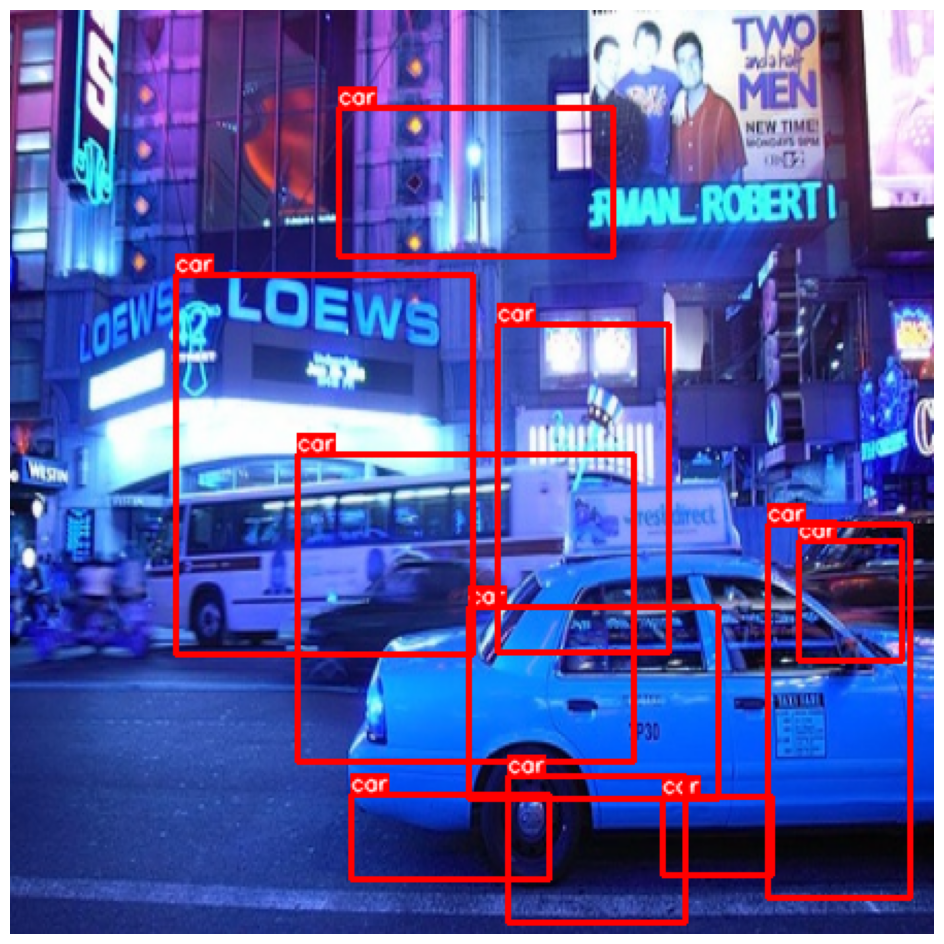

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load and preprocess the image
np_img = cv2.imread('VOCdevkit_test/VOC2007/JPEGImages/000014.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
processed_img = np_img.astype(np.float32)
processed_img = processed_img / 255.0 * 2 - 1
processed_img = np.reshape(processed_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

# Make predictions
y_pred = YOLO(processed_img, training=False)
bbox = process_outputs(y_pred)

# Prepare the prediction results for the visualize function
raw_labels = tf.cast(tf.reshape(bbox, [-1, 6]), tf.float32)
# Remove the last column using indexing
raw_labels = raw_labels[:, :-1]
bboxes = raw_labels.numpy()

# Use the visualize function to display the image and bounding box
visualize(resized_img, bboxes)

# Make Prediction and Output to txt file

In [ ]:
output_file = open('test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))

        # Process predictions and get an array of boxes for this image
        boxes = process_outputs(prediction_step(test_img[i:i+1]))
        boxes = np.array(boxes).reshape(-1, 6)

        # Scale coordinates according to the original image size
        for box in boxes:
            xmin, ymin, xmax, ymax, class_num, conf = box
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

            #clip value between 0, width, height
            xmin = np.clip(xmin, 0, img_w[i])  # Clip between 0 and image width
            ymin = np.clip(ymin, 0, img_h[i])  # Clip between 0 and image height
            xmax = np.clip(xmax, 0, img_w[i])  # Clip between 0 and image width
            ymax = np.clip(ymax, 0, img_h[i])  # Clip between 0 and image height

        #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf))


        # Write to file: img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write("\n")

output_file.close()

/tmp/ipykernel_831307/4153761235.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_file.write(" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf))


In [ ]:
import sys
import os

current_dir = os.getcwd()
sys.path.append(current_dir)

# 導入 evaluate 函數
import sys
from pathlib import Path

sys.path.append(str(Path("evaluate").resolve()))

from evaluate import evaluate

evaluate('./test_prediction.txt', './output_file.csv')


End Evalutation


# The discussion part is as follows

# About data augmentation
On data augmentation, besides from doing flip, saturation change, randormbrightness, blurring and some couarsedropout. We also generate another dataset with cutout implementation. We combine these two dataset and repeat several times and to give a more robust model. The following are some of our augmented data_examples.

demo of cutout

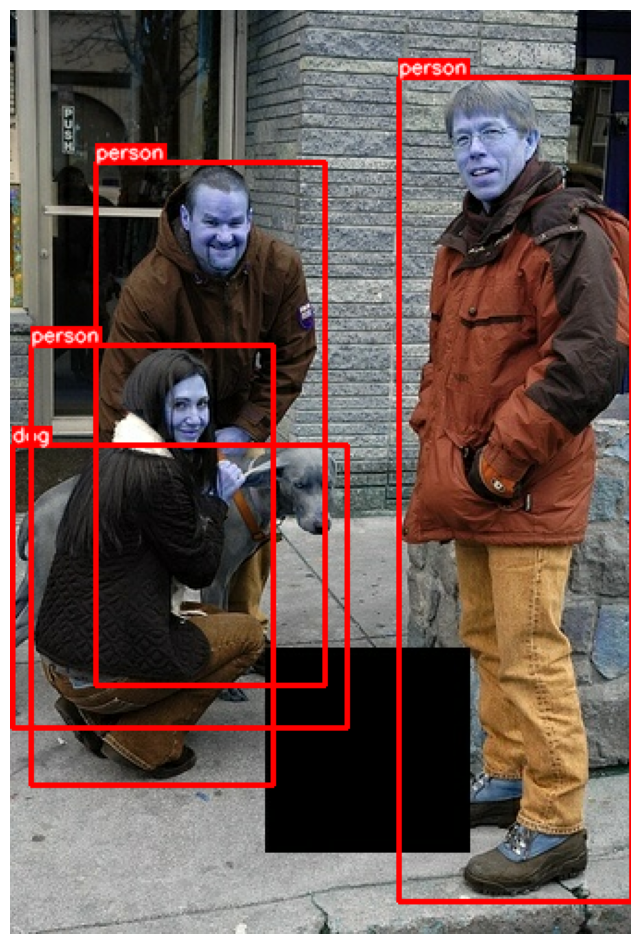

In [ ]:
input_file = open('./data_cutout/cut_out_train_data.txt', 'r')
for i, line in enumerate(input_file):
  if i>10:
    break
  if i==8:
    line = line.strip()
    ss = line.split(' ')

    image_name=ss[0]
    image_file = tf.io.read_file('./data_cutout/cut_out_train_data/'+image_name)
    image = tf.io.decode_jpeg(image_file, channels=3)
    raw_labels = tf.cast(tf.reshape([float(num) for num in ss[1:]], [-1, 5]), tf.float32)
    image = image.numpy()
    bboxes = raw_labels.numpy()
    visualize(image, bboxes)
input_file.close()

demo of other augmentation

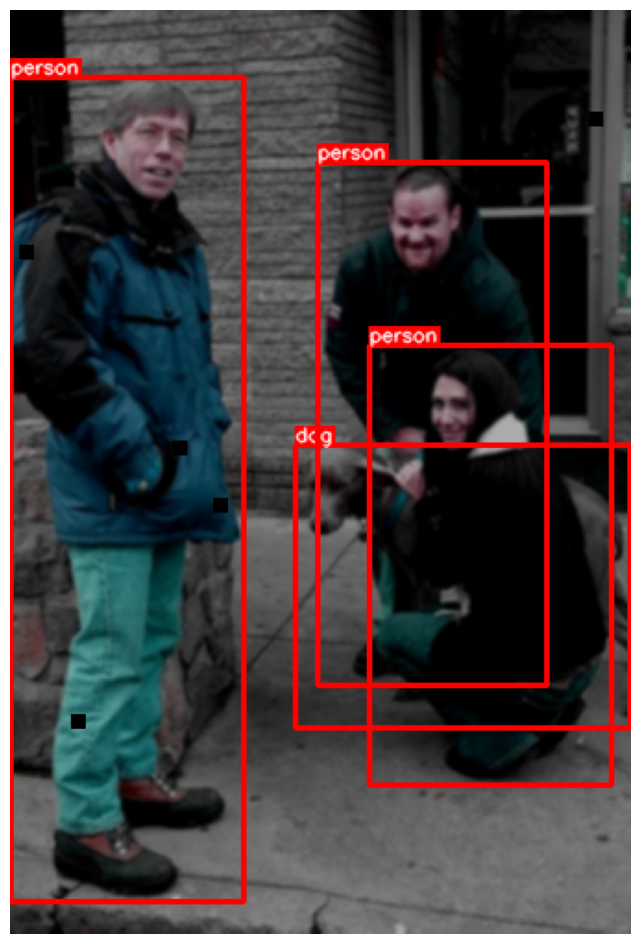

In [ ]:
input_file = open('./2024-datalab-cup2-object-detection/pascal_voc_training_data.txt', 'r')
for i, line in enumerate(input_file):
  if i>10:
    break
  if i==8:
    line = line.strip()
    ss = line.split(' ')

    image_name=ss[0]
    image_file = tf.io.read_file('./2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'+image_name)
    image = tf.io.decode_jpeg(image_file, channels=3)
    raw_labels = tf.cast(tf.reshape([float(num) for num in ss[1:]], [-1, 5]), tf.float32)
    image = image.numpy()
    bboxes = raw_labels.numpy()
    transform = A.Compose([
            A.VerticalFlip(p=0.5),  # Randomly flip the image vertically
            A.HorizontalFlip(p=1),  # Randomly flip the image horizontally
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),  # Adjust hue, saturation, and value
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),  # Adjust brightness and contrast
            A.GaussianBlur(blur_limit=7, p=1),  # Apply random Gaussian blur
            A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, p=1), # Randomly obscured portions of the image
        ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.0))

    aug_data = transform(image = image, bboxes = bboxes)
    aug_image = aug_data["image"]
    aug_bboxes = aug_data['bboxes']
    visualize(aug_image, aug_bboxes)
input_file.close()

# Model modification
On yolov1, we try different image size(224 and 448) and backbone combination (ResNet, VGG, Inception, Xception, DensetNet, NasNetLarge) and we find out that backbone with Xception, DenseNet and NasNetLarge perform the best, and also because DenseNet and NasNetLarge are too large, we can only apply image image size 224 to them while Xception can take both image size 224 and 448 and Xception with image size 448 performs the best among all our experiments.

We also try to unfreeze the layers from 30% to 70% of the backbone models and find it doesn't improve the performance very much, with improvement on loss smaller than 0.5.

And because in yolov1, one grid cell can only predict one objection. We try to use cell size 14 to seperation objects into different cells. But the models become untrainable and easily reach NaN during training.

We also try to add SPP and PAN on YOLOv1 models. But we find out it does not improve the performance.

The following are our final yolov1 hyperparameters and the model.

In [ ]:
# common params
IMAGE_SIZE = 448

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 50

In [ ]:
backbone = Xception(include_top=False,
                       weights='imagenet',
                       input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze 0.7 of the layers
freeze_until = int(len(backbone.layers) * 0.7)

for layer in backbone.layers[:freeze_until]:
    layer.trainable = False

img_inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = backbone(img_inputs)

x = layers.Flatten()(x)

x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)

outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = tf.keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 xception (Functional)       (None, 14, 14, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 4096)              1644171264
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1470)              6022590   
                                                                 
Total params: 1671055334 (6.23 GB)
Trainable params: 166074818

# Optimization of training
In training part, we change our Adam optimizer a little bit,the main purpose is to increase the number of epochs without premature nan. And we also add early stopping to the training. The following are our opitimizations. Our final loss reaches around 3.5.

our modification of Adam opitimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=True)

our EarlyStopping callback

In [ ]:
# 添加Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif current_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0

# About output parameters modification
When manageing output, instead of only output the object with maximum confidence. We set confidence threshold to output every objects with confidence above the threshold. And we also add non max suppression on this. We find out that, because yolov1 has low performance detecting small objects, we need to set confidence very low(around 0.005-0.05) to detect small objects. And despite that it generates more "hallucination" bounding boxes than setting confidence threshold high, it gives a better score because it can detect much more small objects. And on this, because there will be lots of overlapping bounding boxes, we set non max suppression threshold from low to medium level to remove unnessessary bounding boxes. We find out that when combining with low confidence, non max suppresssion threshold around 0.1-0.3 performs the best. The following are our output implementation code.

In [ ]:
MAX_CONF = 0.005
IOU = 0.3

def process_outputs(outputs):
    """
    Process YOLO outputs to extract bounding boxes with class-wise non-max suppression.
    """
    boxes = []

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
    coordinates = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))

    for i in range(CELL_SIZE):
        for j in range(CELL_SIZE):
            # Select the bounding box with the highest confidence score in this grid cell
            cell_confs = confs[0, i, j, :]  # Shape: (2,)
            best_box = np.argmax(cell_confs)
            max_conf = cell_confs[best_box]

            # Only proceed if the confidence score is above the threshold
            #一開始condifence超過0.3的才append到box進入non max suppression的環節
            if max_conf > MAX_CONF:
                # Class probabilities for the best bounding box
                p_class = class_probs[0, i, j, :]
                class_scores = max_conf * p_class  # Shape: (20,)
                class_num = np.argmax(class_scores)
                max_class_conf = class_scores[class_num]

                # Coordinates of the best bounding box
                coord = coordinates[0, i, j, best_box, :]
                xcenter = coord[0]
                ycenter = coord[1]
                w = coord[2]
                h = coord[3]

                # Transform to absolute coordinates
                xcenter = (j + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
                ycenter = (i + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))
                w = w * IMAGE_SIZE
                h = h * IMAGE_SIZE
                xmin = xcenter - w / 2.0
                ymin = ycenter - h / 2.0
                xmax = xmin + w
                ymax = ymin + h

                # Append the bounding box with class and confidence
                boxes.append((xmin, ymin, xmax, ymax, class_num, max_class_conf))

    if len(boxes) == 0:  # Handle the empty box list scenario

       coordinates = np.reshape(coordinates, (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL*4))

       predicts = np.concatenate([class_probs, confs, coordinates], 3)#1,7,7,30

       p_classes = predicts[0, :, :, 0:NUM_CLASSES]#(7, 7, 20)
       C = predicts[0, :, :, NUM_CLASSES:NUM_CLASSES+BOXES_PER_CELL]#(7, 7, 2)
       coordinate = predicts[0, :, :, NUM_CLASSES+BOXES_PER_CELL:]#(7, 7, 8)


       p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, NUM_CLASSES))#(7, 7, 1, 20)
       C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))# (7, 7, 2, 1)

       P = C * p_classes#P's shape [7, 7, 2, 20]

    #choose the most confidence one
       max_conf = np.max(P)
       index = np.argmax(P)

       index = np.unravel_index(index, P.shape)

       class_num = index[3]

       coordinate = np.reshape(coordinate,
                            (CELL_SIZE,
                             CELL_SIZE,
                             BOXES_PER_CELL,
                             4))
       max_coordinate = coordinate[index[0], index[1], index[2], :]

       xcenter = max_coordinate[0]
       ycenter = max_coordinate[1]
       w = max_coordinate[2]
       h = max_coordinate[3]

       xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
       ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

       w = w * IMAGE_SIZE
       h = h * IMAGE_SIZE

       xmin = xcenter - w/2.0
       ymin = ycenter - h/2.0

       xmax = xmin + w
       ymax = ymin + h

       boxes.append([xmin, ymin, xmax, ymax, class_num, max_conf])

    # Convert boxes to a numpy array with shape [-1, 6]
    boxes = np.array(boxes).reshape(-1, 6)

    # Define your IOU threshold and max number of boxes you want to keep per class
    #針對每個class，最多output10個框，和confidence高的重疊超過iou_threshold=0.5的剔除。這邊可自己修正
    iou_threshold = IOU
    max_output_size = 10

    # List to hold final boxes after class-wise NMS
    final_boxes = []

    # Get the unique class numbers
    unique_classes = np.unique(boxes[:, 4])

    # Perform NMS for each class separately
    for class_num in unique_classes:
        # Filter boxes belonging to the current class
        class_boxes = boxes[boxes[:, 4] == class_num]

        # Extract coordinates and confidence scores
        box_coords = class_boxes[:, :4]  # xmin, ymin, xmax, ymax
        scores = class_boxes[:, 5]  # max_conf

        # Convert to TensorFlow tensors
        box_coords = tf.constant(box_coords, dtype=tf.float32)
        scores = tf.constant(scores, dtype=tf.float32)

        # Apply non-max suppression
        selected_indices = tf.image.non_max_suppression(
            box_coords,
            scores,
            max_output_size=max_output_size,
            iou_threshold=iou_threshold)

        # Gather the selected boxes and their scores
        selected_boxes = tf.gather(box_coords, selected_indices).numpy()
        selected_scores = tf.gather(scores, selected_indices).numpy()

        # Append each selected box with class_num and score to final_boxes
        for i in range(len(selected_boxes)):
            final_boxes.append([
                selected_boxes[i][0],  # xmin
                selected_boxes[i][1],  # ymin
                selected_boxes[i][2],  # xmax
                selected_boxes[i][3],  # ymax
                class_num,             # class_num
                selected_scores[i]     # max_conf
            ])

    # 'final_boxes' is now a list of bounding boxes after class-wise NMS
    # Each entry has the format: [xmin, ymin, xmax, ymax, class_num, max_conf]

    return final_boxes

test_img_files = open('pascal_voc_testing_data.txt')
test_img_dir = 'VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts_yolo1_2/YOLO1-store_2/yolo1-4').expect_partial()

@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

The following is an example using the above output parameters. And we find out that when we set confidence threshold to above 0.1. There are only 1-2 cars detected.

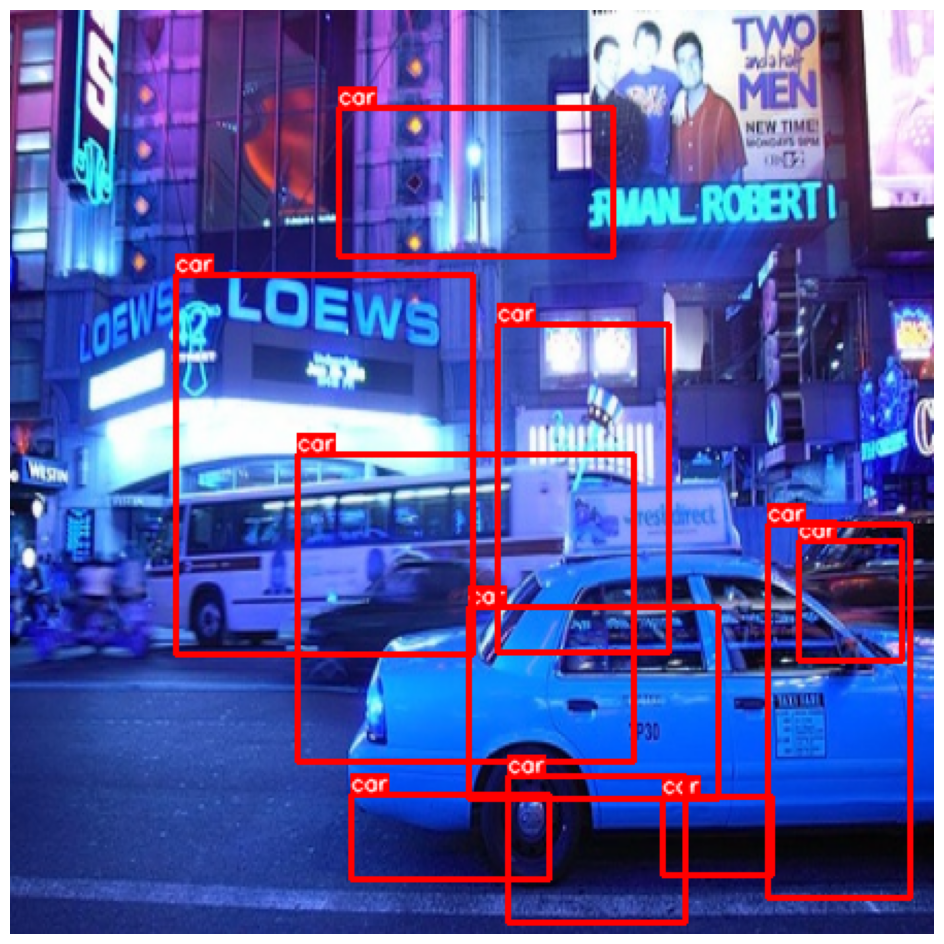

In [ ]:
# Load and preprocess the image
np_img = cv2.imread('VOCdevkit_test/VOC2007/JPEGImages/000014.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
processed_img = np_img.astype(np.float32)
processed_img = processed_img / 255.0 * 2 - 1
processed_img = np.reshape(processed_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

# Make predictions
y_pred = YOLO(processed_img, training=False)
bbox = process_outputs(y_pred)

# Prepare the prediction results for the visualize function
raw_labels = tf.cast(tf.reshape(bbox, [-1, 6]), tf.float32)
# Remove the last column using indexing
raw_labels = raw_labels[:, :-1]
bboxes = raw_labels.numpy()

# Use the visualize function to display the image and bounding box
visualize(resized_img, bboxes)

# About limitations
Because we spend a lot time try to build the yolov3 model. So we don't spend much time to further augment our dataset like doing cropping or disorting the images. And despite we try add SPP and PAN to yolov1, we don't try to alter the structure in other way. Maybe adding more layers or more augmentation would decrease the loss and improve the performance.

# Failure of constructing yolov3 model
We spend a lot of time constructing yolov3 model but we fail.

We use default settings of image size, cell size and anchors from yolov3 to construct our yolov3 models. And because the output of yolo3 is like [grid] x [grid] x [bounding boxes] x [xywh+confidence+num+classes] with each object corresponding to only one anchor box with the best iou from the cell where the object center lies, we also change our DatasetGenerator function. The following is our hyperparameters related to yolov3 model and our modified DatasetGenerator function.

our hyperparameters for yolov3


In [ ]:
# Common params
IMAGE_SIZE = 416
BATCH_SIZE = 32
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 42

# YOLOv3 specific params
ANCHORS = [
    # Small scale anchors - 處理小物體
    # 使用 mean-std 作為基準
    [[10, 13], [16, 30], [33, 23]],

    # Medium scale anchors - 處理中等大小物體
    # 使用接近 mean 的尺寸
    [[30, 61], [62, 45], [59, 119]],

    # Large scale anchors - 處理大物體
    # 使用 mean+std 作為基準
    [[116, 90], [156, 198], [373, 326]]
]
STRIDES = [8, 16, 32]
XYSCALE = [1.05, 1.05, 1.05]

# Model params
CELL_SIZE = [52, 26, 13]  # 416/8, 416/16, 416/32
BOXES_PER_CELL = 3
OUTPUT_CHANNELS = BOXES_PER_CELL * (NUM_CLASSES + 5)  # 75
COORD_SCALE = 4
OBJECT_SCALE = 2
NOOBJECT_SCALE = 2
CLASS_SCALE = 1

# Training params
initial_learning_rate = 1e-4
WARMUP_STEPS = 1
TOTAL_STEPS = 50000
EPOCHS = 100
MIN_LR = 1e-6

about our dataloader, we output correspoinding bounding boxes with grid size 52, 26, 13. The ouptut looks like [label_sbbox, label_mbbox, label_lbbox] corresponding to each cell size.

And for each object, we only broadcast the information of that object to the best iou bounding box of the 9 bounding boxes of the corresponding cell. We put normalized xywh([0,1]), confidence(1) and onehot encoding of the class in the corresponding box.

In [ ]:
class DatasetGenerator:
    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []

        print("Starting to load dataset...")
        input_file = open(DATA_PATH, 'r')

        max_record_length = 0
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            records = [float(num) for num in ss[1:]]
            max_record_length = max(max_record_length, len(records))

        input_file.seek(0)

        max_objects = 0
#測試取一個
        for i, line in enumerate(input_file):
          if i>3:
            break
          if i==3:

            line = line.strip()
            ss = line.split(' ')

            self.image_names.append(ss[0])
            records = [float(num) for num in ss[1:]]
            num_objects = len(records) // 5

            max_objects = max(max_objects, num_objects)

            if len(records) < max_record_length:
                padding = [0.0] * (max_record_length - len(records))
                records.extend(padding)

            self.record_list.append(records)
            self.object_num_list.append(num_objects)

        input_file.close()

        print(f"Dataset loaded:")
        print(f"- Total images: {len(self.image_names)}")
        print(f"- Maximum objects in a single image: {max_objects}")
        print(f"- Record length after padding: {max_record_length}")

    def aug_fn(self, image, bbox):

        # Convert the TensorFlow tensor to a NumPy array
        image = image.numpy()
        bbox = bbox.numpy()

        # Ensure the original bbox is not empty
        if len(bbox) == 0:
            return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(bbox, dtype=tf.float32)
        #augmentation part
        transform = A.Compose([
            A.VerticalFlip(p=0.5),  # Randomly flip the image vertically
            A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=0.5),  # Adjust hue, saturation, and value
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
            A.GaussianBlur(blur_limit=7, p=0.3),  # Apply random Gaussian blur
            A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, p=0.5), # Randomly obscured portions of the image
        ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.0))

        aug_data = transform(image = image, bboxes = bbox)
        aug_image = aug_data["image"]
        aug_bboxes = aug_data['bboxes']

        # Convert the NumPy array back to a TensorFlow tensor
        aug_image = tf.convert_to_tensor(aug_image, dtype=tf.float32)
        aug_bboxes = tf.convert_to_tensor(aug_bboxes, dtype=tf.float32)

        return aug_image, aug_bboxes

    def aug_data(self, image, bbox):
        aug_image, aug_bboxes = tf.py_function(func=self.aug_fn, inp=[image, bbox], Tout=[tf.float32, tf.float32])

        aug_image.set_shape([None, None, 3])
        aug_bboxes.set_shape([None, 5])

        return aug_image, aug_bboxes

    def _data_preprocess(self, image_name, raw_labels, object_num):
        """YOLOv4預處理函數"""
        # 讀取和處理圖像
        image = tf.io.read_file(IMAGE_DIR + image_name)
        image = tf.io.decode_jpeg(image, channels=3)

        # 轉換raw_labels為張量並進行類型轉換
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        #get only rows < object_num
        raw_labels_real = raw_labels[:object_num]
        #set padding aside, later for reconcacenate
        raw_labels_pad = raw_labels[object_num:]

        image, raw_labels_real = self.aug_data(image, raw_labels_real)
        raw_labels = tf.concat([raw_labels_real, raw_labels_pad], axis=0)


        # 獲取原始圖像尺寸
        original_h = tf.cast(tf.shape(image)[0], tf.float32)
        original_w = tf.cast(tf.shape(image)[1], tf.float32)

        # 調整圖像大小並歸一化
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.cast(image, tf.float32) / 255.0 * 2 - 1
        #根據圖像尺寸調整bbox coordinate
        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        # Scale factors
        scale_x = IMAGE_SIZE / original_w
        scale_y = IMAGE_SIZE / original_h

        xmin = xmin * scale_x
        ymin = ymin * scale_y
        xmax = xmax * scale_x
        ymax = ymax * scale_y

        raw_labels = tf.stack([xmin, ymin, xmax, ymax, class_num], axis=-1)

        # 初始化三個尺度的標籤張量
        label_sbbox = tf.zeros((CELL_SIZE[0], CELL_SIZE[0], BOXES_PER_CELL, 5 + NUM_CLASSES), dtype=tf.float32)
        label_mbbox = tf.zeros((CELL_SIZE[1], CELL_SIZE[1], BOXES_PER_CELL, 5 + NUM_CLASSES), dtype=tf.float32)
        label_lbbox = tf.zeros((CELL_SIZE[2], CELL_SIZE[2], BOXES_PER_CELL, 5 + NUM_CLASSES), dtype=tf.float32)

        # 確保object_num是int32類型
        object_num = tf.cast(object_num, tf.int32)

        # 檢查有效的標籤
        valid_labels_mask = tf.logical_and(
            tf.reduce_all(tf.math.is_finite(raw_labels), axis=1),
            tf.reduce_all(tf.math.greater_equal(raw_labels, 0.0), axis=1)
        )
        raw_labels = tf.boolean_mask(raw_labels, valid_labels_mask)

        # 確保shape也是int32類型
        labels_shape = tf.cast(tf.shape(raw_labels)[0], tf.int32)
        object_num = tf.minimum(object_num, labels_shape)

        def process_single_bbox(bbox):
            """處理單個邊界框"""
            bbox_coor = bbox[:4]  # [xmin, ymin, xmax, ymax]
            bbox_class_ind = bbox[4]

            # 確保座標在合理範圍內
            bbox_coor = tf.clip_by_value(bbox_coor, 0,
                                       tf.constant([IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE],
                                                 dtype=tf.float32))

            # 計算中心點和寬高（歸一化到[0,1]範圍）
            bbox_xywh = tf.concat([
                (bbox_coor[2:] + bbox_coor[:2]) * 0.5 / tf.constant([IMAGE_SIZE, IMAGE_SIZE], dtype=tf.float32),
                (bbox_coor[2:] - bbox_coor[:2]) / tf.constant([IMAGE_SIZE, IMAGE_SIZE], dtype=tf.float32)
            ], axis=0)

            return bbox_xywh, bbox_class_ind

        def calculate_iou(anchor_boxes, true_boxes):
            """where is wrong?"""
            # 常量定義
            EPS = 1e-7

            anchor_boxes = tf.cast(anchor_boxes, tf.float32)
            true_boxes = tf.cast(true_boxes, tf.float32)

            # 處理NaN和Inf
            anchor_boxes = tf.where(tf.math.is_finite(anchor_boxes),
                         anchor_boxes,
                         tf.zeros_like(anchor_boxes))
            true_boxes = tf.where(tf.math.is_finite(true_boxes),
                         true_boxes,
                         tf.zeros_like(true_boxes))



            # 分離中心點和寬高
            anchor_xy = anchor_boxes[...,0:2]
            anchor_wh = anchor_boxes[...,2:4]
            true_xy = true_boxes[...,0:2]
            true_wh = true_boxes[...,2:4]

            # 確保寬高為正值
            anchor_wh = tf.maximum(anchor_wh, EPS)
            true_wh = tf.maximum(true_wh, EPS)

            # 計算框的面積
            anchor_area = anchor_wh[..., 0] * anchor_wh[..., 1]
            true_area = true_wh[..., 0] * true_wh[..., 1]

            # 計算框的左上角和右下角
            anchor_mins = anchor_xy - anchor_wh / 2.0
            anchor_maxes = anchor_xy + anchor_wh / 2.0
            true_mins = true_xy - true_wh / 2.0
            true_maxes = true_xy + true_wh / 2.0

            # 計算交集區域
            intersect_mins = tf.maximum(anchor_mins, true_mins)
            intersect_maxes = tf.minimum(anchor_maxes, true_maxes)
            intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.0)
            intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

            # 計算並集區域
            union_area = anchor_area + true_area - intersect_area

            # 計算IOU
            iou = tf.where(
              union_area > EPS,
              intersect_area / union_area,
              tf.zeros_like(union_area)
            )
            iou = tf.clip_by_value(iou, 0.0, 1.0)

            return iou

        def process_scale(bbox_normalized, class_ind, scale_idx):
            grid_size = CELL_SIZE[scale_idx]

            # 將歸一化座標映射到網格尺度
            grid_xy = bbox_normalized[:2] * tf.cast(grid_size, tf.float32)
            grid_xy_int = tf.floor(grid_xy)

            # 確保網格索引在有效範圍內
            grid_xy_int = tf.clip_by_value(tf.cast(grid_xy_int, tf.int32), 0, grid_size - 1)

            #expand_bbox
            bbox_expand = tf.expand_dims(bbox_normalized, 0)  # [1, 2]

            # 創建objectness和類別標籤
            objectness = tf.ones([1, 1], dtype=tf.float32)  # [1, 1]
            class_onehot = tf.one_hot(tf.cast(class_ind, tf.int32), NUM_CLASSES, dtype=tf.float32)  # [NUM_CLASSES]
            class_onehot = tf.expand_dims(class_onehot, 0)  # [1, NUM_CLASSES]


            # 組合標籤(normalized xywh, confidence, classonehot)
            label = tf.concat([bbox_expand, objectness, class_onehot], axis=-1)  # [1, 5 + NUM_CLASSES]

            return grid_xy_int, label


        # 處理每個物體
        for i in tf.range(object_num):
            bbox = raw_labels[i]
            bbox_xywh, class_ind = process_single_bbox(bbox)

            #init iou_tensor
            iou_tensor = tf.zeros((3, 3), dtype=tf.float32)

            grid_list = []

            for scale_idx in range(3):

                grid_xy, label = process_scale(bbox_xywh, class_ind, scale_idx)

                # 確保索引有效
                #grid_y為row num, grid_x為column num
                grid_y = tf.clip_by_value(grid_xy[1], 0, CELL_SIZE[scale_idx] - 1)
                grid_x = tf.clip_by_value(grid_xy[0], 0, CELL_SIZE[scale_idx] - 1)
                grid_list.append([grid_y, grid_x])

                # Create anchor_center
                anchor_center = tf.convert_to_tensor(
                [[tf.cast(grid_xy[0], tf.float32) + 0.5, tf.cast(grid_xy[1], tf.float32) + 0.5]] * 3,
                dtype=tf.float32)

                #normalized anchor_center
                anchor_center = tf.cast(anchor_center, tf.float32) / tf.cast(CELL_SIZE[scale_idx], tf.float32) #x,y
                #get normalized wh
                scale_anchors = tf.constant(ANCHORS[scale_idx], dtype=tf.float32)
                scale_anchors = tf.reshape(scale_anchors, [BOXES_PER_CELL, 2]) / tf.constant([IMAGE_SIZE, IMAGE_SIZE], dtype=tf.float32)#w,h
                normalized_anchors = tf.concat([anchor_center, scale_anchors], axis=-1)

                gt_expanded = tf.expand_dims(bbox_xywh, axis=0)

                iou=calculate_iou(normalized_anchors, gt_expanded)

                # Update the corresponding row of iou_tensor
                indices = tf.constant([[scale_idx]])

                iou_tensor = tf.tensor_scatter_nd_update(iou_tensor, indices, [iou])


            # Find the maximum IoU across all 9 elements
            max_iou_value = tf.reduce_max(iou_tensor)

            # Find the index of the maximum IoU in the flattened (1D) version of the tensor
            max_iou_index = tf.argmax(tf.reshape(iou_tensor, [-1]))

            # Convert the flattened index back to (row, column) format
            #row is scale_idx, column is bbox num
            max_iou_position = tf.unravel_index(max_iou_index, iou_tensor.shape)

            max_iou_position = tf.cast(max_iou_position, tf.int32)


            # 更新對應尺度的標籤張量(如果anchor_box在label_sbbox裡)
            if max_iou_position[0]== 0:
                #grid_y, grid_x網格索引，以(row, column)呈現
                update_index = tf.stack([grid_list[0][0], grid_list[0][1], max_iou_position[1]], axis=0)

                # Reshape `index` to have shape (1, 3)
                update_index = tf.reshape(update_index, (1, 3))

                # Use `tf.tensor_scatter_nd_update` to update the tensor
                label_sbbox = tf.tensor_scatter_nd_update(label_sbbox, update_index, label)

            elif scale_idx == 1:
                #grid_y, grid_x網格索引，以(row, column)呈現
                update_index = tf.stack([grid_list[1][0], grid_list[1][1], max_iou_position[1]], axis=0)

                # Reshape `index` to have shape (1, 3)
                update_index = tf.reshape(update_index, (1, 3))

                # Use `tf.tensor_scatter_nd_update` to update the tensor
                label_mbbox = tf.tensor_scatter_nd_update(label_mbbox, update_index, label)
            else:
                #grid_y, grid_x網格索引，以(row, column)呈現
                update_index = tf.stack([grid_list[2][0], grid_list[2][1], max_iou_position[1]], axis=0)

                # Reshape `index` to have shape (1, 3)
                update_index = tf.reshape(update_index, (1, 3))

                # Use `tf.tensor_scatter_nd_update` to update the tensor
                label_lbbox = tf.tensor_scatter_nd_update(label_lbbox, update_index, label)

        return image, raw_labels, object_num, label_sbbox, label_mbbox, label_lbbox

    def generate(self):
        """生成數據集"""
        # Create dataset from tensor slices
        dataset = tf.data.Dataset.from_tensor_slices((
            self.image_names,
            tf.cast(np.array(self.record_list), tf.float32),
            tf.cast(np.array(self.object_num_list), tf.int32)
        ))

        # Shuffle dataset
        dataset = dataset.shuffle(100000)
        dataset = dataset.repeat(1)#repeat dataset for augmentation

        # Map preprocessing function
        dataset = dataset.map(
            self._data_preprocess,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

        # Batch the dataset
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset

The following code shows an example of the original bounding box and the "responsible" bounding box.

[[0.507      0.44894892 0.39000002 0.5195195  1.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]


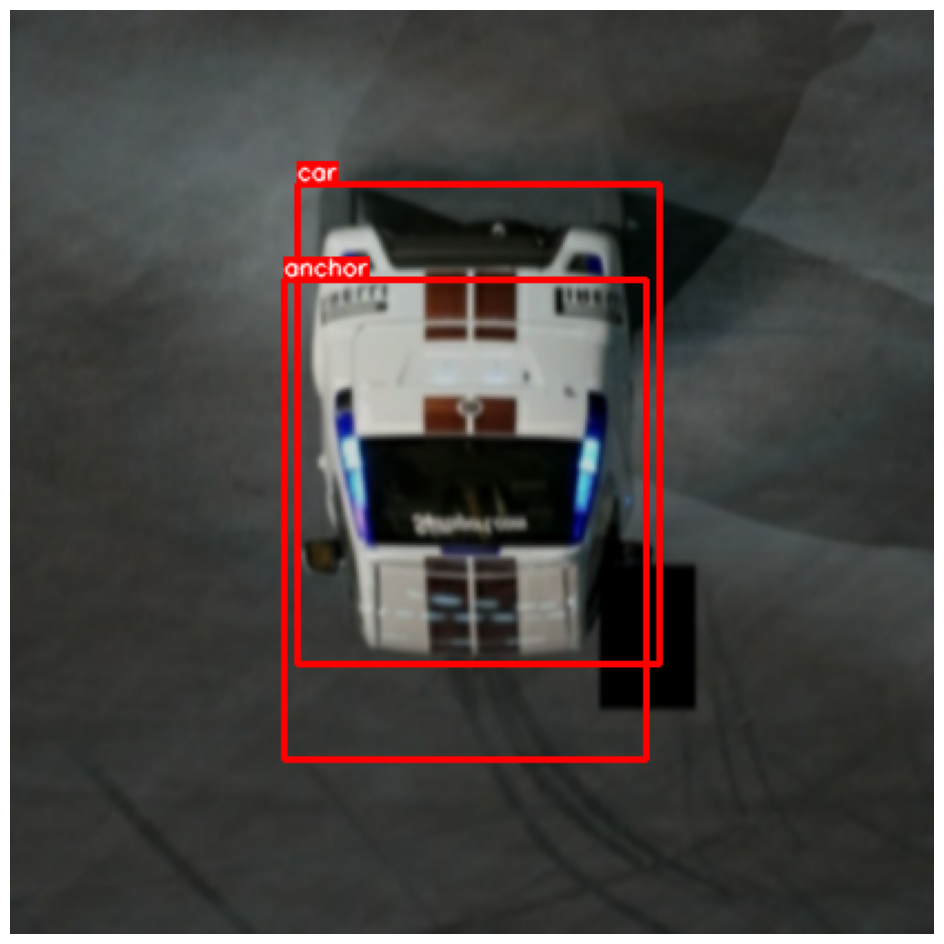

In [ ]:
dataset = DatasetGenerator().generate()
for image, raw_labels, object_num, label_sbbox, label_mbbox, label_lbbox in dataset.take(1):  # Take the first batch
    num_images_in_batch = image.shape[0]  # Get the actual number of images in this batch
    for i in range(num_images_in_batch):  # Iterate over the actual images in the batch
       image_i = image[i].numpy()
       image_i = (image_i+1.0)*255.0/2.0
       image_i = image_i.astype(np.uint8)

       raw_labels_i = raw_labels[i].numpy()
       raw_labels_i = raw_labels_i[:object_num[i]]
       bbox_i = np.reshape(raw_labels_i, [-1, 5])
       label_lbbox_i = label_lbbox[i].numpy()
       filtered = label_lbbox_i[label_lbbox_i[..., 4] == 1]
       print(filtered)
       labeling_xywh = [0.493,      0.5510511,  0.39000005, 0.5195195]
       # Extract components
       x_center, y_center, width, height = labeling_xywh

       # Convert to xmin, ymin, xmax, ymax
       xmin = x_center - width / 2
       ymin = y_center - height / 2
       xmax = x_center + width / 2
       ymax = y_center + height / 2

       labeling_xyxy = np.array([xmin, ymin, xmax, ymax])*IMAGE_SIZE
       labeling_xyxy_with_class = np.append(labeling_xyxy, 20.0)
       labeling_xyxy_with_class = np.expand_dims(labeling_xyxy_with_class, axis=0)
       result = np.concatenate((bbox_i, labeling_xyxy_with_class), axis=0)

       visualize(image_i, result)

#About build yolov3 model
On building yolov3 model, we replace the original CSP-Darnet 53 backbone with ResNet50 because there is no pretrained weights to be used in CSP-Darnet 53 model. And we use lower level features, middle level features and the last layer features, concated with SPP and PAN to generate the final output. The following is our modified yolov3 model.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG16, ResNet50
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Reshape, Activation
from keras.layers import Add, Concatenate
from keras.models import Model
from keras.utils import get_custom_objects

class Mish(Activation):

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x

    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)

    return(ymin+ymax+y)

def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    """卷積塊函數
    Args:
        inp: 輸入張量
        convs: 卷積層配置列表
        skip: 是否使用skip connection
    """
    x = inp
    count = 0
    skip_connection = None  # 先初始化為None

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        # 添加padding如果stride>1
        if conv['stride'] > 1:
            x = ZeroPadding2D(((1,0),(1,0)),
                             name='zerop_' + str(conv['layer_idx']))(x)

        # 卷積層
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)

        # BatchNorm
        if conv['bnorm']:
            x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)

        # 激活函數
        if conv['activ'] == 1:
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2:
            x = Activation('mish', name='mish_' + str(conv['layer_idx']))(x)

    if skip and skip_connection is not None:
        return Add(name='add_' + str(conv['layer_idx']+1))([skip_connection, x])
    return x

def make_yolov3_model():
    input_image = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_0')

    # Load ResNet without the top fully connected layers, keeping only the feature extractor
    resnet = tf.keras.applications.ResNet50(
        include_top=False, weights="imagenet", input_tensor=input_image)
    # Freeze 0.7 of the layers
    freeze_until = int(len(resnet.layers) * 0.7)
    for layer in resnet.layers[:freeze_until]:
        layer.trainable = False

    layer_4 = resnet.get_layer("conv3_block4_out").output  # Use this as a lower feature map (e.g., 76x76)
    layer_11 = resnet.get_layer("conv4_block6_out").output  # Middle feature map (e.g., 38x38)
    layer_16 = resnet.get_layer("conv5_block3_out").output  # Top feature map (e.g., 19x19)


    x = layer_16

    #SPP
    x_5 = MaxPool2D(pool_size=(5, 5), strides=1, padding='same')(x)
    x_9 = MaxPool2D(pool_size=(9, 9), strides=1, padding='same')(x)
    x_13 = MaxPool2D(pool_size=(13, 13), strides=1, padding='same')(x)
    x = Concatenate(name='concat_100')([x, x_5, x_9, x_13])

    #[convolutional]
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 101},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 102},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 103}])
    layer_103 = x

    #[convolutional]
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 104}])
    layer_104 = x

    #[upsample]
    x = UpSampling2D(size=(2, 2), name = 'upsamp_105')(x)
    layer_105 = x

    #[route] layers = 11
    x = layer_11

    #[convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106}])
    layer_106 = x

    #[concat]
    x = Concatenate(name='concat_107')([layer_106, layer_105])
    layer_107 = x


    #[convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 108},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 109},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 110},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 111},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 112}])
    layer_112 = x


    #[convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 113}])
    layer_113 = x

    #[upsample]
    x = UpSampling2D(size=(2, 2), name = 'upsamp_114')(x)
    layer_114 = x

    # ---------------------------------- begin head output 76*76 ---------------------------------------
    #[route] layers = 4
    x = layer_4

    #[convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115}])
    layer_115 = x

    #[concat]
    x = Concatenate(name='concat_116')([layer_115, layer_114])
    layer_116 = x

    #[convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 117},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 118},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 119},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 120},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 121}])
    layer_121 = x

    #[convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 122}])
    layer_122 = x

    #[convolutional]
    x = _conv_block(x, [{'filter':  75, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 123}])

    # -- output 76*76
    yolo_124 = x

    # ---------------------------------- end head output 76*76 ---------------------------------------

    # ---------------------------------- begin head output 38*38 ---------------------------------------
    #[route] layers = -4
    x = layer_121

    ##  Layer 141 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 125}])
    layer_125 = x

    #[concat]
    x = Concatenate(name='concat_126')([layer_125, layer_112])

    #[convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 127},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 128},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 129},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 130},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 131}])
    layer_131 = x

    #[convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  75, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 133}])

    # -- output 38*38
    yolo_134 = x

    # ---------------------------------- end head output 38*38 ---------------------------------------

    # ---------------------------------- begin head output 19*19 ---------------------------------------
    #[route] layers = -4
    x = layer_131

    #[convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 135}])
    layer_135 = x

    #[concat]
    x = Concatenate(name='concat_136')([layer_135, layer_103])


    #[convolutional]
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 137},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 138},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 139},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 140},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 141},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 142},
                        {'filter':   75, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 143}])

    # -- output 19*19
    yolo_143 = x

    # ---------------------------------- end head output 19*19 ---------------------------------------

    model = Model(input_image, [yolo_124, yolo_134, yolo_143], name = 'Yolo_v3')
    return model

In [ ]:
model = make_yolov3_model()
model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 422, 422, 3)          0         ['input_0[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 208, 208, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 208, 208, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Define loss
On loss define, both yolov1 and yolov3 are constructed from coord loss, obj loss, no-obj loss and classes loss. But there are still some small modification on loss design in yolov3 model.

First is the coordinate loss. Instead of iou, it uses giou instead, which also counts into the relationship of how the two bounding boxes overlap. And we then use 1-giou as our coord losses. According to the reference, we also know that, the return values of the predicted xy is the corresponding position in the certain cell and wh is log(w/anchors) and log(h/anchols). So we also modify our coordinate generation code of the predicted bounding boxes.

And about no-obj loss, according to the reference, we should only punish the non responsible predicted boxes with iou<0.5(predefined threshold) to all true bounding boxes. So we also change our no-obj loss according to this.

Finally on obj loss, also according to the reference, we change our true confidence to confidence * giou, which not just represents the confidence of having object or not but also reflects the information of the confidence of boudning box prediction.

Our final prediction is really bad and we can see from the following that not just the bounding boxes distorted and distant from the objects, the predicted classes and confidences are really weird. I think the problem may still lie in the predicted bounding boxes coordinate calculation because if the bounding box's position is distant form where it should be and shape distorted, first it will affect confidence since the confidence is also calculated from giou. And because the object position and shape is displaced, the class prediction may be wrong. But we check the code several times and still cannot find the bug so we finally give up.

the following is our loss calculation function

In [ ]:
def process_labels(true_class, smoothing=0.1):
    """添加標籤平滑"""
    num_classes = tf.shape(true_class)[-1]
    smooth_value = smoothing / tf.cast(num_classes, tf.float32)
    smooth_labels = (1.0 - smoothing) * true_class + smooth_value
    return smooth_labels

# Metrics for each output scale
train_loss_metrics = {
    'total': tf.keras.metrics.Mean(name='total_loss'),
    # 各尺度的總損失
    'small': tf.keras.metrics.Mean(name='small_scale_loss'),
    'medium': tf.keras.metrics.Mean(name='medium_scale_loss'),
    'large': tf.keras.metrics.Mean(name='large_scale_loss'),
    # 各尺度的組件損失
    'small_coord': tf.keras.metrics.Mean(name='small_coord_loss'),
    'small_obj': tf.keras.metrics.Mean(name='small_obj_loss'),
    'small_noobj': tf.keras.metrics.Mean(name='small_noobj_loss'),
    'small_class': tf.keras.metrics.Mean(name='small_class_loss'),

    'medium_coord': tf.keras.metrics.Mean(name='medium_coord_loss'),
    'medium_obj': tf.keras.metrics.Mean(name='medium_obj_loss'),
    'medium_noobj': tf.keras.metrics.Mean(name='medium_noobj_loss'),
    'medium_class': tf.keras.metrics.Mean(name='medium_class_loss'),

    'large_coord': tf.keras.metrics.Mean(name='large_coord_loss'),
    'large_obj': tf.keras.metrics.Mean(name='large_obj_loss'),
    'large_noobj': tf.keras.metrics.Mean(name='large_noobj_loss'),
    'large_class': tf.keras.metrics.Mean(name='large_class_loss'),
}

def calculate_giou(pred_boxes, true_boxes):
    """改進的GIOU損失計算

    Args:
        pred_boxes: 預測框 shape: [cell_size, cell_size, 3, 4]
        true_boxes: 真實框 shape: [cell_size, cell_size, 4] 或 [cell_size, cell_size, 3, 4]

    Returns:
        giou: 計算出的GIOU損失 shape: [cell_size, cell_size, 3]
    """
    # 數值穩定性常數
    EPS = 1e-7

    # 檢查並處理輸入
    pred_boxes = tf.cast(pred_boxes, tf.float32)
    true_boxes = tf.cast(true_boxes, tf.float32)

    # 處理NaN和Inf
    pred_boxes = tf.where(tf.math.is_finite(pred_boxes),
                         pred_boxes,
                         tf.zeros_like(pred_boxes))
    true_boxes = tf.where(tf.math.is_finite(true_boxes),
                         true_boxes,
                         tf.zeros_like(true_boxes))



    # 分離中心點和寬高
    pred_xy = pred_boxes[..., 0:2]
    pred_wh = pred_boxes[..., 2:4]
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    # 確保寬高為正值
    pred_wh = tf.maximum(pred_wh, EPS)
    true_wh = tf.maximum(true_wh, EPS)

    # 計算框的面積
    pred_area = pred_wh[..., 0] * pred_wh[..., 1]
    true_area = true_wh[..., 0] * true_wh[..., 1]

    # 計算框的左上角和右下角
    pred_mins = pred_xy - pred_wh / 2.0
    pred_maxes = pred_xy + pred_wh / 2.0
    true_mins = true_xy - true_wh / 2.0
    true_maxes = true_xy + true_wh / 2.0

    # 計算交集區域
    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    # 計算並集區域
    union_area = pred_area + true_area - intersect_area

    # 計算IOU
    iou = tf.where(
        union_area > EPS,
        intersect_area / union_area,
        tf.zeros_like(union_area)
    )
    iou = tf.clip_by_value(iou, 0.0, 1.0)

    # 計算中心點距離
    center_dist = tf.reduce_sum(tf.square(pred_xy - true_xy), axis=-1)

    # 計算封閉矩形的對角線距離
    enclose_mins = tf.minimum(pred_mins, true_mins)
    enclose_maxes = tf.maximum(pred_maxes, true_maxes)
    enclose_wh = tf.maximum(enclose_maxes - enclose_mins, 0.0)
    enclose_area = enclose_wh[..., 0] * enclose_wh[..., 1]

    # 計算GIOU
    giou = iou - tf.abs(enclose_area-union_area) / (enclose_area+EPS)
    giou = tf.clip_by_value(giou, -1.0, 1.0)#shape should be 52,52,3?

    # 添加調試信息
    tf.debugging.check_numerics(giou, "CIOU calculation produced invalid values")

    return giou

def losses_calculation(predict, label, cell_size, anchors, stride, xyscale):
    """損失計算函數 - 使用完整的參數配置
    Args:
        predict: 模型預測 [cell_size, cell_size, 3, 25] (3是BOXES_PER_CELL, 25是5+NUM_CLASSES)
        label: 真實標籤 [cell_size, cell_size, 3, 25]
        cell_size: 特徵圖大小
        anchors: 當前尺度的anchor boxes
        stride: 當前尺度的步長
        xyscale: 當前尺度的xy縮放因子
    """
    EPS = 1e-7

    # 1. 重塑輸出
    predict = tf.reshape(predict, [cell_size, cell_size, BOXES_PER_CELL, -1])#52(row),52(column),3,25
    label = tf.reshape(label, [cell_size, cell_size, BOXES_PER_CELL, -1])#52(row),52(column),3,25

    cell_column = tf.cast((tf.reshape(tf.tile(tf.range(cell_size), [cell_size]), (cell_size, cell_size,1,1))),dtype=tf.float32)#52,52,1,1
    cell_row = tf.transpose(cell_column, (1,0,2,3))#52,52,1,1

    cell_grid = tf.tile(tf.concat([cell_column, cell_row], -1), [1, 1, BOXES_PER_CELL, 1])#52,52,3,2 each with (column,row)=(x,y)


    # 2. 預測框解碼(使用正確的縮放參數)
    pred_xy = tf.sigmoid(predict[..., 0:2])
    pred_xy = pred_xy + cell_grid #(我自己的理解)cell x, y
    pred_xy = pred_xy *stride #original xy

    pred_wh = tf.exp(predict[..., 2:4]) * anchors #(我自己的理解)real wh of image size
    pred_wh = pred_wh #original wh (我自己的理解)
    pred_conf = tf.sigmoid(predict[..., 4])
    pred_class = tf.sigmoid(predict[..., 5:])

    # 3. 組合預測框
    pred_box = tf.concat([pred_xy, pred_wh], axis=-1)#original xywh 52,52,3,4

    # 4. 處理標籤
    true_box = label[..., 0:4]*IMAGE_SIZE#use original xywh
    true_class = label[..., 5:]

    # 5. 計算CIOU
    giou = calculate_giou(pred_box, true_box)#52,52,3

    ###用giou代表真實confidence
    true_conf = giou * label[..., 4]#(52, 52, 3)

    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is an object in the cell i, else 0.

    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is an object in the cell i, else 0.
    coord_mask = label[..., 4] * COORD_SCALE#52,52,3


    ### objectness mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    bd = label[..., :4]*IMAGE_SIZE #original coord
    nozero = tf.not_equal(bd, tf.zeros((cell_size, cell_size, BOXES_PER_CELL, 4)))
    true_boxes = tf.boolean_mask(bd, nozero)#concat all none zero xywh together

    s=tf.squeeze(tf.size(true_boxes)//4)#s is the number of ground truth
    true_boxes=tf.reshape(true_boxes, (s,4))

    true_boxes = tf.expand_dims(true_boxes,0)
    true_boxes = tf.expand_dims(true_boxes,0)
    true_boxes = tf.expand_dims(true_boxes,0)#(1, 1, 1, None=s, 4)



    #true_boxes(8, 1, 1, 1, None=MAX_OBJECTS_PER_IMAGE, 4)#bdd need to do padding for ensuring a fixed shape(by chat gpt)
    pred_boxes_xy = tf.expand_dims(pred_xy, 3)#(52, 52, 3, 2)->(52, 52, 3, 1, 2) original coord
    pred_boxes_wh = tf.expand_dims(pred_wh, 3)#original coord
    pred_boxes = tf.concat([pred_boxes_xy, pred_boxes_wh], axis=-1)#(52, 52, 3, 1, 4)

    giou_boxes = calculate_giou(pred_boxes, true_boxes)#(1, 1, 1, None, 4) (52, 52, 3, 1, 4) (52, 52, 3, None)
    best_ious = tf.reduce_max(giou_boxes, axis=-1)#(52,52,3)#best iou of each preding box to every ground truth


    no_obj_mask = tf.cast((best_ious < 0.5),dtype=tf.float32) * (1 - label[..., 4]) * NOOBJECT_SCALE#only if best_iou<0.6 and y false, contribute to NOOBJECT_SCALE
    have_obj_mask = label[..., 4] * OBJECT_SCALE#if y true, contribute to OBJECT_SCALE(52, 52, 3)

    ### class mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is a particular class is predicted, else 0.
    class_weights = np.ones(NUM_CLASSES, dtype='float32')#(NUM_CLASSES,)

    true_class_indices = tf.argmax(true_class, axis=-1)
    class_mask = label[..., 4] * tf.gather(class_weights, true_class_indices) * CLASS_SCALE#(52, 52, 3)


    nb_coord_box = tf.reduce_sum(tf.cast((coord_mask > 0.0),dtype=tf.float32))#number
    nb_no_obj_box  = tf.reduce_sum(tf.cast((no_obj_mask  > 0.0),dtype=tf.float32))#number
    nb_have_obj_box = tf.reduce_sum(tf.cast((have_obj_mask > 0.0),dtype=tf.float32))#number
    nb_class_box = tf.reduce_sum(tf.cast((class_mask > 0.0),dtype=tf.float32))#number


    ### loss
    #in loss_xy, loss_wh, only calculate those with object(true_conf=1)
    #these are all normalized values
    giou_loss_value = 1 - giou
    coord_loss = tf.reduce_sum(coord_mask * giou_loss_value)/ (nb_coord_box + EPS)

    noobj_loss = tf.reduce_sum(no_obj_mask * tf.square(true_conf-pred_conf)) / (nb_no_obj_box + EPS)
    obj_loss   = tf.reduce_sum(have_obj_mask * tf.square(true_conf-pred_conf)) / (nb_have_obj_box + EPS)


    class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_class_indices, logits=pred_class)

    class_loss = tf.reduce_sum(class_mask * class_loss) / (nb_class_box + EPS)



    return {
        'coord': coord_loss,
        'obj': obj_loss,
        'noobj': noobj_loss,
        'class': class_loss
    }

@tf.function
def yolo_loss(predicts, labels, objects_num):
    """計算YOLOv4的總損失
    Args:
        predicts: list of 3 tensors [batch_size, cell_size, cell_size, 255]
                 (255 = BOXES_PER_CELL * (5 + NUM_CLASSES))
        labels: list of 3 tensors [batch_size, cell_size, cell_size, 3, 25]
        objects_num: [batch_size] 每張圖片中的物體數量
    """
    total_loss = 0.0

    # 初始化各尺度的損失
    scale_losses = {
        'small': {'coord': 0.0, 'obj': 0.0, 'noobj': 0.0, 'class': 0.0},
        'medium': {'coord': 0.0, 'obj': 0.0, 'noobj': 0.0, 'class': 0.0},
        'large': {'coord': 0.0, 'obj': 0.0, 'noobj': 0.0, 'class': 0.0}
    }

    # 處理每個尺度的預測
    scales = ['small', 'medium', 'large']
    for scale_idx, (pred, label) in enumerate(zip(predicts, labels)):
        scale_name = scales[scale_idx]
        cell_size = CELL_SIZE[scale_idx]  # [52, 26, 13]
        curr_anchors = np.array(ANCHORS[scale_idx])  # 取得當前尺度的anchors
        curr_stride = STRIDES[scale_idx]  # [8, 16, 32]
        curr_xyscale = XYSCALE[scale_idx]  # [1.05, 1.05, 1.05]

        # 處理每個batch
        batch_size = tf.shape(pred)[0]
        for batch_idx in range(batch_size):
            pred_single = pred[batch_idx]  # 當前batch的預測
            label_single = label[batch_idx]  # 當前batch的標籤

            # 確保數值穩定性
            pred_single = tf.debugging.check_numerics(
                pred_single,
                f"pred_single contains NaN in scale {scale_name}"
            )
            label_single = tf.debugging.check_numerics(
                label_single,
                f"label_single contains NaN in scale {scale_name}"
            )

            # 計算損失
            losses = losses_calculation(
                predict=pred_single,
                label=label_single,
                cell_size=cell_size,
                anchors=curr_anchors,
                stride=curr_stride,
                xyscale=curr_xyscale
            )

            # 更新該尺度的損失
            scale_losses[scale_name]['coord'] += losses['coord']
            scale_losses[scale_name]['obj'] += losses['obj']
            scale_losses[scale_name]['noobj'] += losses['noobj']
            scale_losses[scale_name]['class'] += losses['class']

            # 累加到總損失
            current_loss = sum(losses.values())
            total_loss += current_loss

    # 計算平均損失
    actual_batch_size = tf.cast(tf.shape(predicts[0])[0], tf.float32)

    # 更新metrics
    for scale_name in ['small', 'medium', 'large']:
        scale_losses[scale_name]['coord'] /= actual_batch_size
        scale_losses[scale_name]['obj'] /= actual_batch_size
        scale_losses[scale_name]['noobj'] /= actual_batch_size
        scale_losses[scale_name]['class'] /= actual_batch_size

        # 更新metrics時確保值不為0
        train_loss_metrics[f'{scale_name}_coord'].update_state(
            scale_losses[scale_name]['coord'])
        train_loss_metrics[f'{scale_name}_obj'].update_state(
            scale_losses[scale_name]['obj'])
        train_loss_metrics[f'{scale_name}_noobj'].update_state(
            scale_losses[scale_name]['noobj'])
        train_loss_metrics[f'{scale_name}_class'].update_state(
            scale_losses[scale_name]['class'])

        # 更新總尺度損失
        scale_total = (scale_losses[scale_name]['coord'] +
                      scale_losses[scale_name]['obj'] +
                      scale_losses[scale_name]['noobj'] +
                      scale_losses[scale_name]['class'])
        train_loss_metrics[scale_name].update_state(scale_total)

    # 更新總損失
    total_loss = total_loss / actual_batch_size
    train_loss_metrics['total'].update_state(total_loss)

    return total_loss

the following shows some of our prediction using the yolov3 model. We can see not only bounding boxes distorted but also it detects lots of unexisting objects with high confidence.


Visualizing some test results...


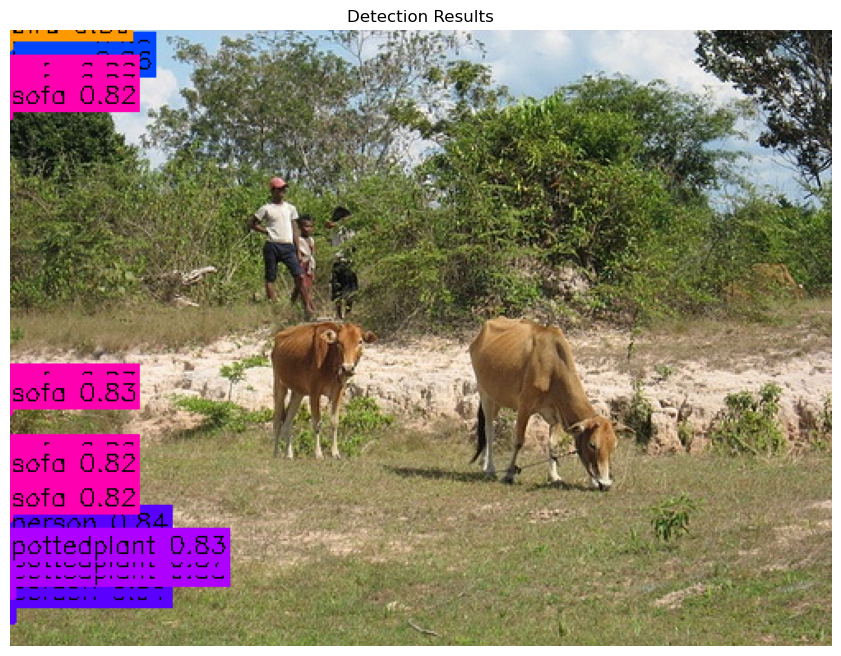

Detected cow with confidence 0.93
Bounding box: [ 0.         0.         5.1202393 11.845937 ]

Detected person with confidence 0.91
Bounding box: [  0.        351.31622     2.6032267 360.71585  ]

Detected bird with confidence 0.90
Bounding box: [ 0.         14.1409      0.47665095 17.334997  ]

Detected horse with confidence 0.90
Bounding box: [ 0.         21.420483    0.44455495 24.854513  ]

Detected person with confidence 0.89
Bounding box: [  0.        344.7063      2.2758396 352.8429   ]

Detected pottedplant with confidence 0.88
Bounding box: [  0.        338.35403     2.1503599 345.6518   ]

Detected pottedplant with confidence 0.87
Bounding box: [  0.        331.01926     2.4247458 340.059    ]

Detected horse with confidence 0.86
Bounding box: [ 0.        28.47163    0.5865712 32.144234 ]

Detected bird with confidence 0.86
Bounding box: [ 0.         6.9783106  0.9217955 11.782218 ]

Detected sofa with confidence 0.86
Bounding box: [ 0.        35.547943   0.5568939 39.128513 

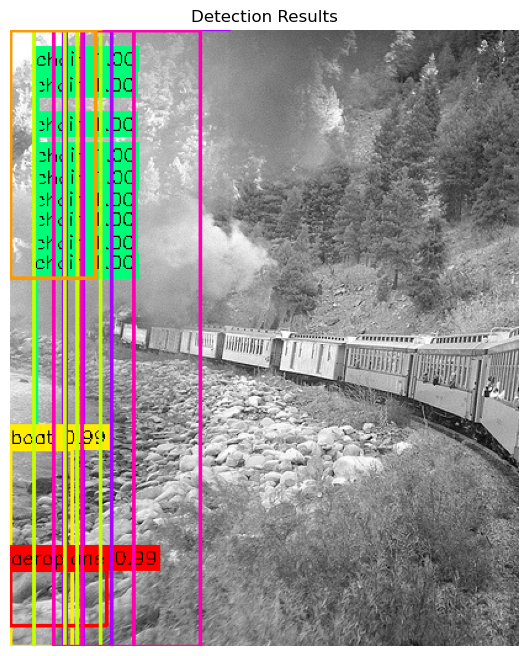

Detected chair with confidence 1.00
Bounding box: [ 19.945677 182.5287    20.742254 278.73355 ]

Detected chair with confidence 1.00
Bounding box: [ 19.412909 163.00685   20.079628 259.8965  ]

Detected chair with confidence 1.00
Bounding box: [ 20.608643 111.333855  21.617458 196.1034  ]

Detected chair with confidence 1.00
Bounding box: [ 19.44147  147.88579   20.104826 236.61029 ]

Detected chair with confidence 1.00
Bounding box: [ 20.69029  129.59372   21.600996 216.39835 ]

Detected chair with confidence 1.00
Bounding box: [ 19.99805  86.87677  20.97538 182.18808]

Detected chair with confidence 1.00
Bounding box: [ 19.918236  54.1573    21.14085  176.68338 ]

Detected chair with confidence 1.00
Bounding box: [ 20.17782  201.38492   21.234112 298.3296  ]

Detected chair with confidence 1.00
Bounding box: [ 20.486269  33.74065   22.83109  159.09993 ]

Detected chair with confidence 1.00
Bounding box: [ 19.844511 198.52853   21.984894 339.9676  ]

Detected pottedplant with confiden

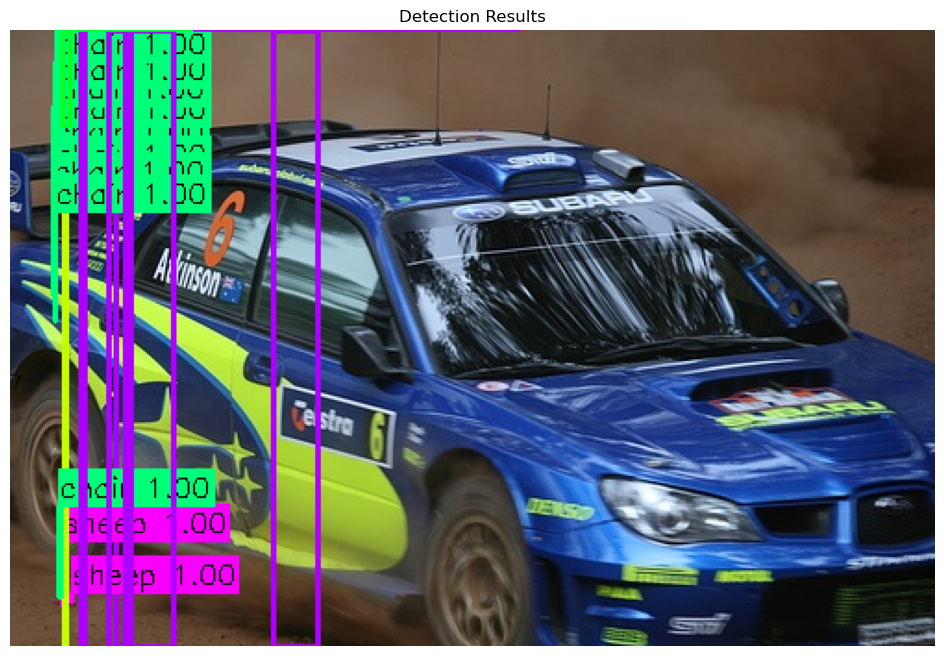

Detected pottedplant with confidence 1.00
Bounding box: [ 57.572525   0.        57.870518 333.      ]

Detected sheep with confidence 1.00
Bounding box: [ 33.28927 304.95786  33.9393  309.1756 ]

Detected boat with confidence 1.00
Bounding box: [ 38.85197    0.        38.964108 333.      ]

Detected sheep with confidence 1.00
Bounding box: [ 28.460825 276.8666    28.640697 311.98975 ]

Detected bottle with confidence 1.00
Bounding box: [ 29.708672   0.        30.17378  333.      ]

Detected chair with confidence 1.00
Bounding box: [ 26.860243 257.06882   27.163282 306.18173 ]

Detected chair with confidence 1.00
Bounding box: [ 23.832388  64.26895   24.345709 114.82085 ]

Detected chair with confidence 1.00
Bounding box: [ 24.018797  77.01382   24.568407 127.69818 ]

Detected chair with confidence 1.00
Bounding box: [ 24.003004  52.54665   24.533133 100.90506 ]

Detected chair with confidence 1.00
Bounding box: [ 23.94091   86.974846  24.513147 143.3502  ]

Detected chair with confiden

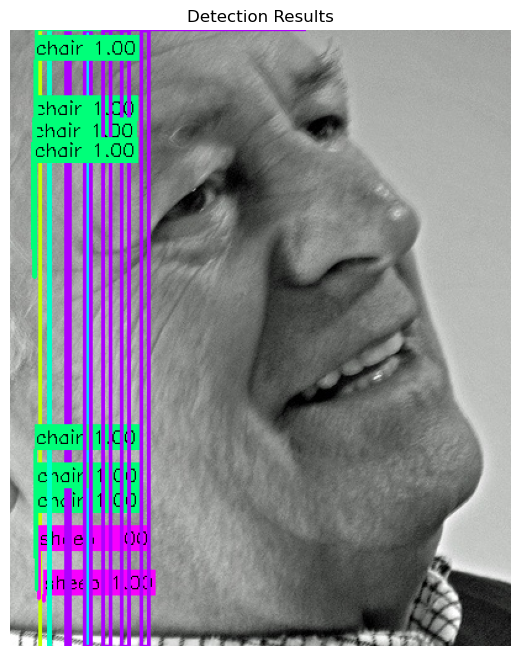

Detected pottedplant with confidence 1.00
Bounding box: [ 46.949566   0.        47.0604   500.      ]

Detected sheep with confidence 1.00
Bounding box: [ 27.433678 458.32727   27.837296 463.79382 ]

Detected boat with confidence 1.00
Bounding box: [ 31.566055   0.        31.63316  500.      ]

Detected bottle with confidence 1.00
Bounding box: [ 24.531672   0.        24.786175 500.      ]

Detected sheep with confidence 1.00
Bounding box: [ 23.23696  422.23462   23.334383 461.8752  ]

Detected chair with confidence 1.00
Bounding box: [ 21.50782  391.33554   21.685873 454.34195 ]

Detected diningtable with confidence 1.00
Bounding box: [ 62.391705   0.        63.177094 500.      ]

Detected pottedplant with confidence 1.00
Bounding box: [ 45.98771    0.        48.598717 500.      ]

Detected chair with confidence 1.00
Bounding box: [ 21.398373 371.11334   21.788    436.15356 ]

Detected cow with confidence 1.00
Bounding box: [ 31.73326    0.        32.515446 500.      ]

Detected chair

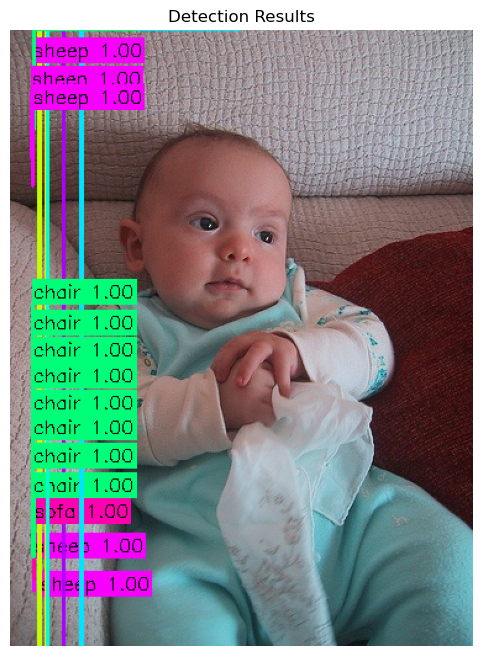

Detected sheep with confidence 1.00
Bounding box: [ 24.772493 459.0686    24.995516 463.0511  ]

Detected sheep with confidence 1.00
Bounding box: [ 19.937387 428.18588   19.97334  455.7643  ]

Detected pottedplant with confidence 1.00
Bounding box: [ 43.386696   0.        43.446915 500.      ]

Detected boat with confidence 1.00
Bounding box: [ 29.16499    0.        29.207678 500.      ]

Detected bottle with confidence 1.00
Bounding box: [ 23.914707   0.        24.06116  500.      ]

Detected sofa with confidence 1.00
Bounding box: [ 19.04751  400.5039    19.115602 445.02216 ]

Detected chair with confidence 1.00
Bounding box: [ 18.940111 379.6944    19.100689 427.42758 ]

Detected cow with confidence 1.00
Bounding box: [ 30.114866   0.        30.530003 500.      ]

Detected diningtable with confidence 1.00
Bounding box: [ 57.756824   0.        58.17804  500.      ]

Detected chair with confidence 1.00
Bounding box: [ 18.369278 355.5493    18.602062 413.2003  ]

Detected chair with c

In [ ]:
def detect_and_visualize(image_path):
    """統一的檢測和可視化函數"""
    # 創建檢測器
    detector = YOLOv4Detector(confidence_threshold=0.4)

    # 讀取圖像
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError(f"Could not read image: {image_path}")

    original_size = original_image.shape[:2]

    # 預處理
    input_image = cv2.resize(original_image, (IMAGE_SIZE, IMAGE_SIZE))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image.astype(np.float32) / 255.0 * 2 - 1
    input_image = np.expand_dims(input_image, 0)

    # 預測
    predictions = model(input_image, training=False)
    predictions = [p.numpy() for p in predictions]

    # 處理預測結果
    boxes, scores, classes = detector.process_predictions(predictions, original_size)

    # 視覺化
    result_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    result_image = detector.visualize_detections(result_image, boxes, scores, classes)

    # 顯示結果
    plt.figure(figsize=(12, 8))
    plt.imshow(result_image)
    plt.axis('off')
    plt.title('Detection Results')
    plt.show()

    # 打印結果
    for box, score, class_id in zip(boxes, scores, classes):
        print(f"Detected {CLASSES[int(class_id)]} with confidence {score:.2f}")
        print(f"Bounding box: {box}\n")

def visualize_test_results(num_samples=5):
    """視覺化一些測試結果"""
    print("\nVisualizing some test results...")

    # 隨機選擇一些圖像
    sample_indices = np.random.choice(len(test_images), num_samples, replace=False)
    for idx in sample_indices:
        image_path = os.path.join(test_img_dir, test_images[idx])
        detect_and_visualize(image_path)

visualize_test_results()

# Summary:

In this competition, we learned more about the implementation of algorithms related to object detection. The architecture of yolov3 and v4 is complex. Even though we spent a lot of time detecting errors, we still failed in the end. The structure of v1 is relatively simple, but this also means that the results are relatively limited.

After trying v3 to no avail, we tried our best to modify v1 so that it can obtain good test results on kaggle. Unexpectedly, we found that the results were not completely positively correlated with the apparent results ( Of course, it may only be when the loss is not low enough).

This means that we can try to deliver results as early as possible in subsequent competitions. Even if the current performance seems not to be good, we can better decide the direction of adjustment by observing changes in score trends.We are trying to submit results until the final deadline, and the spirit of never giving up is the best motivation for progress.